In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from functions import *

import statsmodels.nonparametric.api as nparam
from statsmodels.nonparametric.kernel_regression import KernelReg

from scipy.optimize import minimize
from multiprocess import Pool

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Let $X \sim U[-2,2]$ and 

\begin{equation}
Y_i=a\left\{X_i+2 \exp \left(-16 X_i^2\right)\right\}+\sigma\left(X_i\right) \varepsilon_i
\end{equation}

where $\varepsilon \sim \mathcal{N} \left(0,1\right)$.

The variance function is described by

\begin{equation}
\sigma \left(x \right) = 0.4 \exp \left(-2 x^2\right)+0 \cdot 2
\end{equation}



We estimate the relationship with the Nadaraya-Watson estimator

\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} Y_{i} K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} K \left(
    \frac{x-X_{i} }{h}
    \right)}.
\end{equation}

We assume that the predictor $X$ is missing at random and is observed with the probability of observation
\begin{equation}
\pi \left(Y_i\right) = \frac{1}{1+\exp^{-\left(\beta_{0} +\beta_{1}Y_{i}\right)}}
\end{equation}

that is modelled with the logit function.

If $\pi \left(y \right)$ is known, the Horwitz-Thompson estimator is 
\begin{equation}
m_{n} \left(x\right) = \frac{
\sum_{i=1}^{n} 
\frac{\Omega_{i}Y_{i}}{
\pi \left(Y_{i} \right)
}
 K \left(
    \frac{x-X_{i} }{h}
    \right)
}{\sum_{i=1}^{n} 
\frac{\Omega_{i}}{
\pi \left(Y_{i} \right)
}
K \left(
    \frac{x-X_{i} }{h}
    \right)},
\end{equation}

If  $\pi \left(y \right)$ is unknown, we estimate it with m

In [2]:
#Set params

n = 400

#Data generation 
X = np.random.uniform(-2,2,n)
X.sort()

eps = np.random.normal(0, 1,  n)

In [3]:
target = lambda a: fan(X,n,a,eps)

#Missing values 

b0 = -0.7
b1 =  -1

In [4]:
a =1.5

y = target(a)

In [5]:
omega = bernoulli.rvs(pi(y,b0,b1), size=n)

df = pd.DataFrame({'x':X,'y':y,'omega':omega})

#ipw

df['y_pi'] =  df['y'].apply(lambda t: t/pi(t,b0,b1))

df['var'] = df['x'].apply(lambda t: sigma_reg(t,len(df)))

df_cc = df.loc[df['omega']==1].reset_index(drop=True)

In [6]:
size = round(len(df_cc)*100/len(df))
size

32

In [7]:
#Model calibration

model = KernelReg(endog=[df.y],exog=[df.x],reg_type='lc',var_type='c', bw='cv_ls')

model_cc = KernelReg(endog=[df_cc.y],exog=[df_cc.x],reg_type='lc',var_type='c', bw='cv_ls')

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:238: RuntimeWarning: invalid value encountered in divide
  G = G_numer / G_denom
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:250: RuntimeWarning: invalid value encountered in divide
  B_x = d_mx / f_x - G * d_fx / f_x
/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)


In [8]:
def r_parallel_ipw(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return (df.omega[j]/pi(df.y[j],b0,b1))*(df.y[j]-y_hat)**2 #/pi(df.y[j],b0,b1)

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))
    
def r_parallel_cc(h):
    #print(1)
    def fn(j):
        df1 = df.drop([j],axis=0)
        y_hat = df.omega[j]*nw_mis(h,df.x[j],df1.x,df1.y,pi(df1.y,b0,b1),df1.omega)
        return df.omega[j]*(df.y[j]-y_hat)**2 #/pi(df.y[j],b0,b1)

    with Pool(8) as p:
        return np.mean(p.map(fn, range(len(df))))

In [9]:
%%time
# r_parallel(0.1)
h_ipw_ipw  = minimize(r_parallel_ipw, 0.1).x

h_ipw_cc = minimize(r_parallel_cc, 0.1).x

CPU times: user 12.6 s, sys: 1.45 s, total: 14.1 s
Wall time: 26.5 s


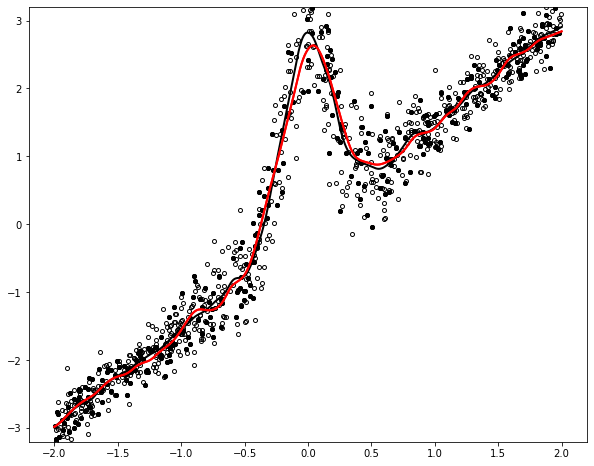

In [10]:
fig, ax = plt.subplots(1, 1,figsize=(10, 8))

plt.plot(df['x'],df['y'],'o',mfc='none',color='black',markersize=4)
plt.plot(df_cc['x'],df_cc['y'],'o',color='black',markersize=4)
#First plot 

#Complete-cases
#ax.plot(df_cc['x'], df_cc['y'], 'o', color='grey',markersize=3)
#Truth
ax.plot(np.linspace(-2, 2, n),model.fit(np.linspace(-2, 2, n))[0] ,color= 'black', lw=2)
#CC estimator 
#ax.plot(np.linspace(-2, 2, n),model_cc.fit(np.linspace(-2, 2, n))[0] ,color= 'red', lw=2)
#CV bandwidth 
ax.plot(np.linspace(-2, 2, n),[nw_mis(h_ipw_cc,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'red', lw=2)

ax.plot(np.linspace(-2, 2, n),[nw_mis(h_ipw_ipw,t,X,y,pi(y,b0,b1),omega) for t in np.linspace(-2, 2, n)],color= 'red', lw=2)


ax.set_ylim(-3.2,3.2)

plt.savefig(f'figures/Regression_{a}_{size}.pdf',transparent=True)


In [11]:
ICE_full = [(fan(t,n,a,0) - model.fit([t])[0][0])**2 for t in np.linspace(-2, 2, n)]
ICE_CC = [(fan(t,n,a,0) - model_cc.fit([t])[0][0])**2 for t in np.linspace(-2, 2, n)]
ICE_IPW = [(fan(t,n,a,0) - nw_mis(h_ipw_ipw,t,X,y,pi(y,b0,b1),omega))**2 for t in np.linspace(-2, 2, n)]

print('ICE FULL:' +str(np.trapz(ICE_full,x=np.linspace(-2, 2, n))))
print('ICE CC:' +str(np.trapz(ICE_CC,x=np.linspace(-2, 2, n))))
print('ICE IPW:' +str(np.trapz(ICE_IPW,x=np.linspace(-2, 2, n))))

ICE FULL:0.018848547140420172
ICE CC:0.06532227019243737
ICE IPW:0.06531520206553465


In [12]:
#ICE comparison

In [13]:
df['res'] = df['y'] - model.fit(df['x'])[0]
df_cc['res_ipw'] = df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw_ipw,t,X,y,pi(y,b0,b1),omega))


In [14]:
df_cc['res_ipw_hcc'] = df_cc['y'] - df_cc['x'].apply(lambda t:nw_mis(h_ipw_cc,t,X,y,pi(y,b0,b1),omega))

In [15]:
df.res

0     -0.356865
1     -0.000832
2     -0.219441
3     -0.065930
4     -0.204798
         ...   
995   -0.068471
996    0.156591
997    0.118406
998    0.042245
999    0.194227
Name: res, Length: 1000, dtype: float64

In [16]:
ICE_full = [(fan(t,n,a,0) - model.fit([t])[0][0])**2 for e,t in zip(np.linspace(-2, 2, n),eps)]

/Users/lilimatic/opt/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_regression.py:251: RuntimeWarning: invalid value encountered in divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)


In [17]:
ICE_IPW = [(fan(t,n,a,0) - nw_mis(h_ipw_ipw,t,X,y,pi(fan(t,n,a,e),b0,b1),omega))**2 for e,t in zip(np.linspace(-2, 2, n),eps)]